# Smart Cities, Lab 1: Digital Equity Plans 
INFO 5455, Cornell Tech, Prof. Anthony Townsend. Developed by Matt Franchi (@mattwfranchi).


In this lab, we review the 2021 Digital Equity Plan of the US city of Philadelphia, Pennsylvania, and use empirical datasets from the [American Community Survey](https://www.census.gov/programs-surveys/acs) to explore the themes and goals of the report relative to a nearby city: New York. 

## 0. Module Imports
To run the below cell, you will need to have the listed packages installed. I will provide pip install commands for the case of using Google Colab. 

In [1]:
!pip install pandas geopandas matplotlib

In [2]:
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt 
# disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None
import os
import sys 
sys.path.append("../../utils")
from logger import setup_logger
from acs import parse_md
from acs import merge_acs_data, verify_acs_data
# set up logging
logger = setup_logger("lab1-DEPs")
logger.setLevel("INFO")

logger.success("Setup complete.")


2025-01-29 11:23:08 - lab1-DEPs - SUCCESS - Setup complete.


## 1. Loading Data 
Prior to running these cells, you should have pulled all data via the scripts in pull/. 

In [3]:
# the first year of ACS data that you want to load 
ACS_YEAR_START = 2017
# the last year of ACS data that you want to load
ACS_YEAR_END = 2022

logger.info(f"Will load ACS datasets from {ACS_YEAR_START} to {ACS_YEAR_END}.")

2025-01-29 11:23:08 - lab1-DEPs - INFO - Will load ACS datasets from 2017 to 2022.


In [4]:
ct_nyc = gpd.read_file('data/ct-nyc-2020.geojson')

In [5]:
# American Community Survey (ACS) data
DATASETS = {
    'dp05': 'Housing and Demographic Estimates',
    's2801': 'Types of Computers and Internet Subscriptions',
    's1501': 'Education Attainment',
    's1901': 'Income',
    's1602': 'Language Spoken at Home',
}

In [6]:
PARSE_MD = True 
os.makedirs('data/dictionaries', exist_ok=True)
if PARSE_MD:
    # parse and write the md for each dataset 
    for dataset in DATASETS.keys():
        md = pd.read_json(f'data/acs{ACS_YEAR_START}_{dataset}_md.json')
        md = parse_md(md)
        md.to_csv(f'data/dictionaries/acs_{dataset}_md.csv', index=False)

Found 714 columns in the dataset
Found 250 columns in the dataset
Found 1538 columns in the dataset
Found 258 columns in the dataset
Found 82 columns in the dataset


In [7]:
# Define all column mappings in a nested dictionary structure
ACS_COLUMNS = {
    'dp05': {
        'name': 'Housing and Demographic Estimates',
        'columns': {
            'DP05_0001E': 'total_population',
            'DP05_0079E': 'nhl_white_alone', 
            'DP05_0080E': 'nhl_black_alone', 
            'DP05_0073E': 'hispanic_alone', 
            'DP05_0082E': 'nhl_asian_alone'
        }
    },
    's2801': {
        'name': 'Types of Computers and Internet Subscriptions',
        'columns': {
            'S2801_C01_012E': 'num_households_with_internet',
            'S2801_C01_005E': 'num_households_with_smartphone'
        }
    },
    's1901': {
        'name': 'Income',
        'columns': {
            'S1901_C01_012E': 'median_household_income'
        }
    },
    's1501': {
        'name': 'Education Attainment',
        'columns': {
            'S1501_C01_009E': 'num_high_school_graduates',
            'S1501_C01_012E': 'num_bachelors_degree',
            'S1501_C01_013E': 'num_graduate_degree'
        }
    },
    's1602': {
        'name': 'Language Spoken at Home',
        'columns': {
            'S1602_C03_001E': 'num_limited_english_speaking_households'
        }
    }
}

In [8]:
# Process the data by merging acs datasets onto the shapefile of NYC census tracts
ct_nyc_processed = merge_acs_data(ct_nyc, ACS_YEAR_START, ACS_YEAR_END, ACS_COLUMNS)

# Verify the results
verify_acs_data(ct_nyc_processed, ACS_COLUMNS)

# If you need to add a new dataset later, just add it to ACS_COLUMNS like this:
"""
ACS_COLUMNS['new_dataset_code'] = {
    'name': 'New Dataset Name',
    'columns': {
        'NEW_CODE_001E': 'friendly_column_name',
        'NEW_CODE_002E': 'another_column_name'
    }
}
"""
logger.success("Data processing complete.")

2025-01-29 11:23:24 - lab1-DEPs - SUCCESS - Data processing complete.



Data Verification Report:
Number of census tracts: 2325
Years present: [2017, 2018, 2019, 2020, 2021, 2022]
Expected columns present: 12/12

All expected columns are present!


In [9]:
# Summary statistics for the median household income column across NYC census tracts
ct_nyc_processed['median_household_income'].describe()

count    1.307700e+04
mean    -2.832524e+07
std      1.346465e+08
min     -6.666667e+08
25%      4.583300e+04
50%      6.664500e+04
75%      8.895800e+04
max      2.500010e+05
Name: median_household_income, dtype: float64

## 3. Sample Plots 

In [10]:
# keep first value for object columns, and means for numeric columns
def first_or_mean(series):
    if series.dtype == 'object':
        return series.iloc[0]
    elif series.dtype == 'int64' or series.dtype == 'float64':
        return series.mean()
    else:
        return series.iloc[0]

# group by year and aggregate
ct_nyc_aggregated = gpd.GeoDataFrame(ct_nyc_processed.groupby(['GEOID']).agg(first_or_mean), crs=ct_nyc.crs, geometry='geometry')
ct_nyc_aggregated.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2325 entries, 36005000100 to 36085990100
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   OBJECTID                                 2325 non-null   float64 
 1   CTLabel                                  2325 non-null   object  
 2   BoroCode                                 2325 non-null   object  
 3   BoroName                                 2325 non-null   object  
 4   CT2020                                   2325 non-null   object  
 5   BoroCT2020                               2325 non-null   object  
 6   CDEligibil                               0 non-null      object  
 7   NTAName                                  2325 non-null   object  
 8   NTA2020                                  2325 non-null   object  
 9   CDTA2020                                 2325 non-null   object  
 10  CDTANAME        

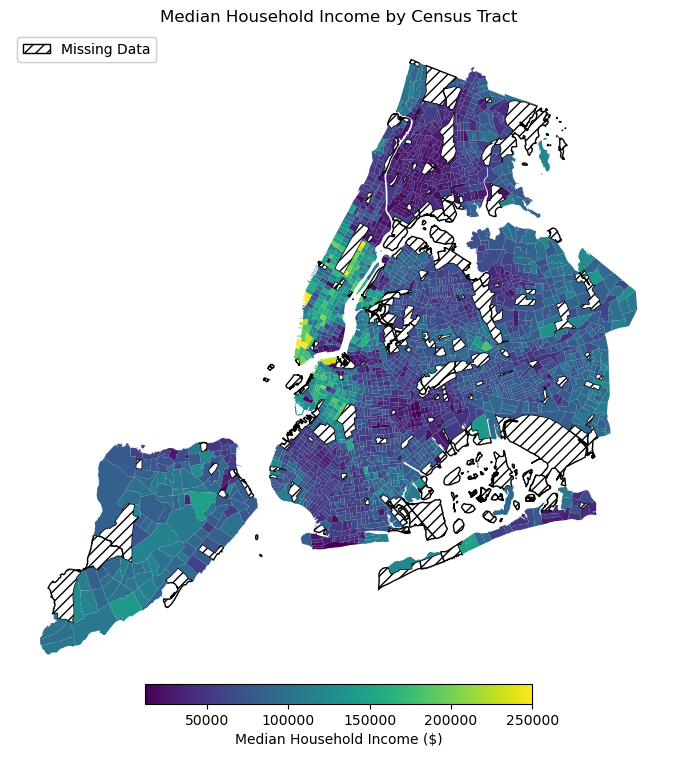

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot missing data
ct_nyc_aggregated[ct_nyc_aggregated['median_household_income'] < 0].plot(
    ax=ax, 
    color='white',
    edgecolor='black',
    hatch='///'
)

# Plot valid data with colorbar
ct_nyc_aggregated[ct_nyc_aggregated['median_household_income'] > 0].plot(
    column='median_household_income', 
    ax=ax, 
    legend=True,
    legend_kwds={'label': 'Median Household Income ($)', 'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.0}
)

# Create and add custom legend for missing data
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='white', edgecolor='black', hatch='///', label='Missing Data')
]

# Create a separate legend for the missing data indicator
legend2 = ax.legend(handles=legend_elements, loc='upper left')

# Add this legend as a second artist
ax.add_artist(legend2)

plt.title('Median Household Income by Census Tract')

ax.axis('off')

plt.show()

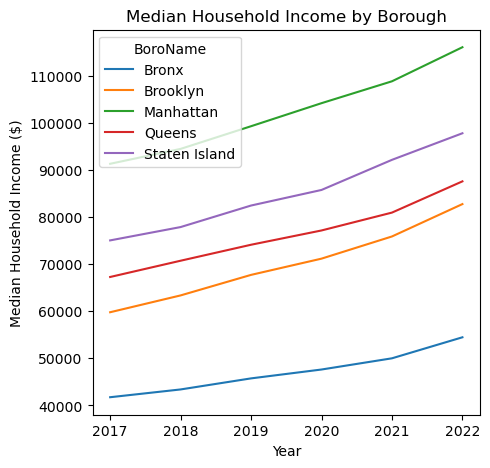

In [12]:
# plot mhi across borough by year 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ct_nyc_processed[ct_nyc_processed['median_household_income'] > 0].groupby(['year','BoroName'])['median_household_income'].mean().unstack().plot(ax=ax)

# use integer ticks for the x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel('Median Household Income ($)')
ax.set_xlabel('Year')
plt.title('Median Household Income by Borough')

plt.show()
